In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from skopt.plots import plot_convergence
from scipy.stats import reciprocal
import skopt
from skopt import gp_minimize
import numpy as np
import pandas as pd
from sklearn import metrics
import datetime
import re
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from tensorflow import keras

# Load Data from Sources

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print(f'Train Shape: {x_train_full.shape} {y_train_full.shape}')
print(f'Test Shape: {x_test.shape} {y_test.shape}')

Train Shape: (60000, 28, 28) (60000,)
Test Shape: (10000, 28, 28) (10000,)


# Data Pre-Processing

In [4]:
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0
temp = []
for i in x_train_full:
    temp.append(i.flatten())
x_train_full = np.array(temp)
temp = []
for i in x_test:
    temp.append(i.flatten())
x_test = np.array(temp)
del temp
# x_test = np.array([ val.flatten() for val in x_test ])
print(f'{x_train_full.shape} {x_test.shape}')

(60000, 784) (10000, 784)


# Simple Model Build

In [23]:
sm_model = SVC()
sm_model.fit(x_train_full, y_train_full)

SVC()

In [24]:
sm_predicted = sm_model.predict(x_test)
accuracy_score(sm_predicted, y_test)

0.8828

# Hyper-Parameter Tuning

In [6]:
SPACE = [
    skopt.space.Categorical(['rbf', 'sigmoid', 'poly'], name='kernel'),
    skopt.space.Categorical([2, 3, 4], name='degree'),
    skopt.space.Real(1e-1, 1e3, prior='log-uniform', name='C')
]

In [7]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    mse_scores = []
    
    cv = KFold(5)
    for train_idx, val_idx in cv.split(x_train_full, y_train_full):
        x_tr, x_val, = x_train_full[train_idx], x_train_full[val_idx]
        y_tr, y_val = y_train_full[train_idx], y_train_full[val_idx]
        
        model = SVC(
            kernel=params['kernel'],
            degree=params['degree'], # only used with poly kernel
            C=params['C']
        )
        
        model.fit(x_tr, y_tr)
        trial_score = accuracy_score(y_val, model.predict(x_val))
        mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(mse_scores)}')
    return -np.mean(mse_scores)

In [8]:
opt_results = gp_minimize(objective, SPACE, n_calls=10, random_state=2)

Avg Validation MSE: 0.8699833333333334
Avg Validation MSE: 0.8785833333333333
Avg Validation MSE: 0.9036666666666665
Avg Validation MSE: 0.8993666666666668
Avg Validation MSE: 0.8983833333333333
Avg Validation MSE: 0.9019
Avg Validation MSE: 0.8518166666666666
Avg Validation MSE: 0.8819166666666666
Avg Validation MSE: 0.8869
Avg Validation MSE: 0.4197


In [9]:
dump(opt_results, 'tuning/opt_results.pkl')

In [10]:
opt_loaded = load('tuning/opt_results.pkl')

In [13]:
print(f"""
    Best Avg. Val MSE: {opt_loaded.fun:.4f}
    Best Parameters:
    - Kernel: {opt_loaded.x[0]}
    - Degree: {opt_loaded.x[1]}
    - C: {opt_loaded.x[2]}
""")


    Best Avg. Val MSE: -0.9037
    Best Parameters:
    - Kernel: rbf
    - Degree: 2
    - C: 8.72375857854421



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

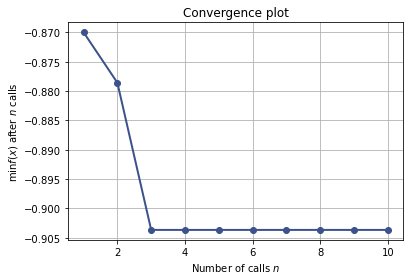

In [14]:
plot_convergence(opt_loaded)

# Model Performance & Evaluation

In [15]:
opt_loaded.x

['rbf', 2, 8.72375857854421]

In [16]:
clf = SVC(
    kernel='rbf',
    C=8.72375857854421
)

In [17]:
clf.fit(x_train_full, y_train_full)

SVC(C=8.72375857854421)

In [18]:
predictions = clf.predict(x_test)

In [20]:
accuracy_score(predictions, y_test)

0.8998

[Text(0.5, 1.0, 'Fashion MNIST Confusion Matrix'),
 Text(0.5, 69.0, 'Predicted Values'),
 Text(69.0, 0.5, 'Actual Labels')]

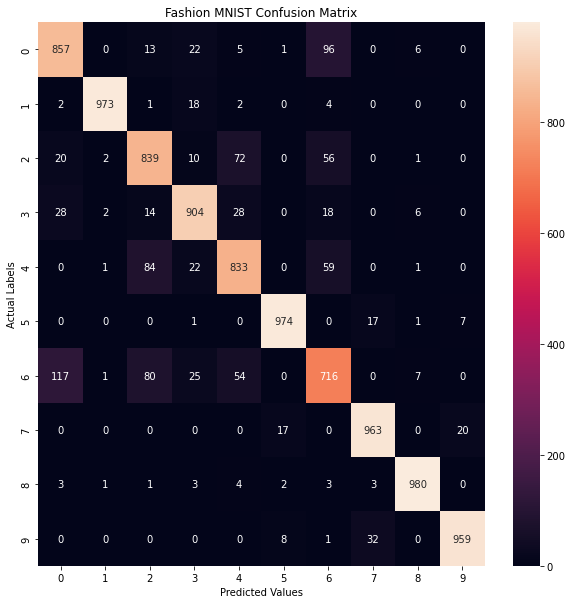

In [21]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, annot=True, fmt='d')
hm.set(title='Fashion MNIST Confusion Matrix', xlabel='Predicted Values', ylabel='Actual Labels')

In [22]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.83      1000
           3       0.90      0.90      0.90      1000
           4       0.83      0.83      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.72      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

